In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

In [ ]:
# Constants:
CRS_LATLON = "EPSG:4326"
CRS_WEB_MERCATOR = "EPSG:3857"
COMMUTE_MODE_COL = "How did you travel to work each day in the last week? Please select the mode that you use for the majority of the commute. *Driving children under 16 to school is NOT considered a carpool. Select \"Drove Alone\" for this scenario."
REMOTE_POLICY_COL = "What is your company's remote work policy?"

COMMUTE_GROUPS = [
    "Drove alone", "Telecommute", "Carpool/Vanpooling", "Walking", "Bus",
    "Did not work", "Bike", "E-bike", "Lyft, Uber, or Taxi"
]
REMOTE_POLICY_GROUPS = [
    "Do not go into workplace 3-4 days a week",
    "Do not go into workplace 1-2 days a week",
    "Must be in the workplace every day",
    "Totally flexible: am not required to go into workplace on regular basis"
]

In [5]:
# Paths
CSV_PATH = "/Users/louis/Downloads/raw data/geocoded_results.csv"
BLOCK_GROUP_SHP = "/Users/louis/Downloads/tl_2024_30_bg/tl_2024_30_bg.shp"

# Load geocoded data and block groups
df = pd.read_csv(CSV_PATH)
block_groups = gpd.read_file(BLOCK_GROUP_SHP).to_crs(CRS_WEB_MERCATOR)

In [17]:
# Create GeoDataFrame
def create_geodf(dataframe, lat_col, lon_col):
    df_clean = dataframe.dropna(subset=[lat_col, lon_col])
    gdf = gpd.GeoDataFrame(
        df_clean,
        geometry=gpd.points_from_xy(df_clean[lon_col], df_clean[lat_col]),
        crs=CRS_LATLON
    )
    return gdf.to_crs(CRS_WEB_MERCATOR)

In [21]:
# Plotting function
def plot_group_map(df, filter_col, filter_val, address_type="home", title=None):
    if address_type == "home":
        gdf = create_geodf(df[df[filter_col] == filter_val], "Home_Lat", "Home_Lon")
    else:
        gdf = create_geodf(df[df[filter_col] == filter_val], "Work_Lat", "Work_Lon")

    joined = gpd.sjoin(gdf, block_groups, how="inner", predicate="within")
    counts = joined.groupby("GEOID")["geometry"].count().reset_index()
    counts.columns = ["GEOID", "count"]
    bg = block_groups.merge(counts, on="GEOID", how="left")
    bg["count"] = bg["count"].fillna(0)

    fig, ax = plt.subplots(figsize=(14, 12))
    bg.plot(
        column="count",
        cmap="OrRd",
        linewidth=0.5,
        edgecolor="black",
        legend=True,
        ax=ax,
        alpha=0.5
    )

    if not gdf.empty:
        bounds = gdf.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.1
        ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)
    ax.set_title(title or f"{filter_val} – {address_type.title()} Distribution", fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

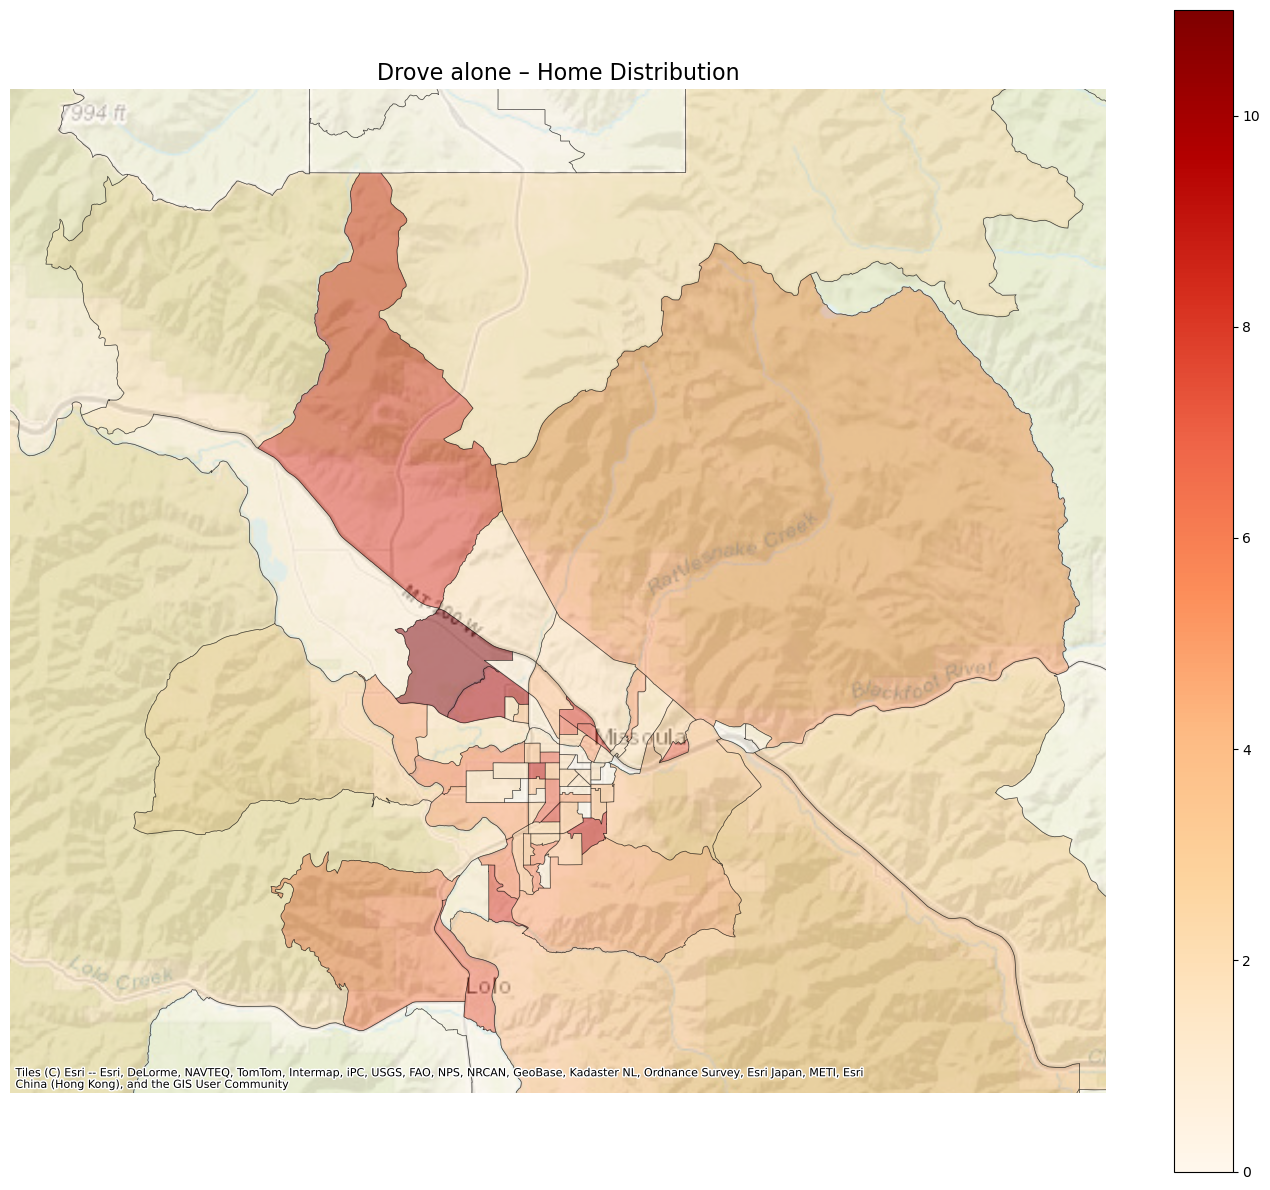

In [ ]:
# Plot all commute groups by home
for group in COMMUTE_GROUPS:
    plot_group_map(df, COMMUTE_MODE_COL, group, address_type="home", title=f"{group} – Home Distribution")

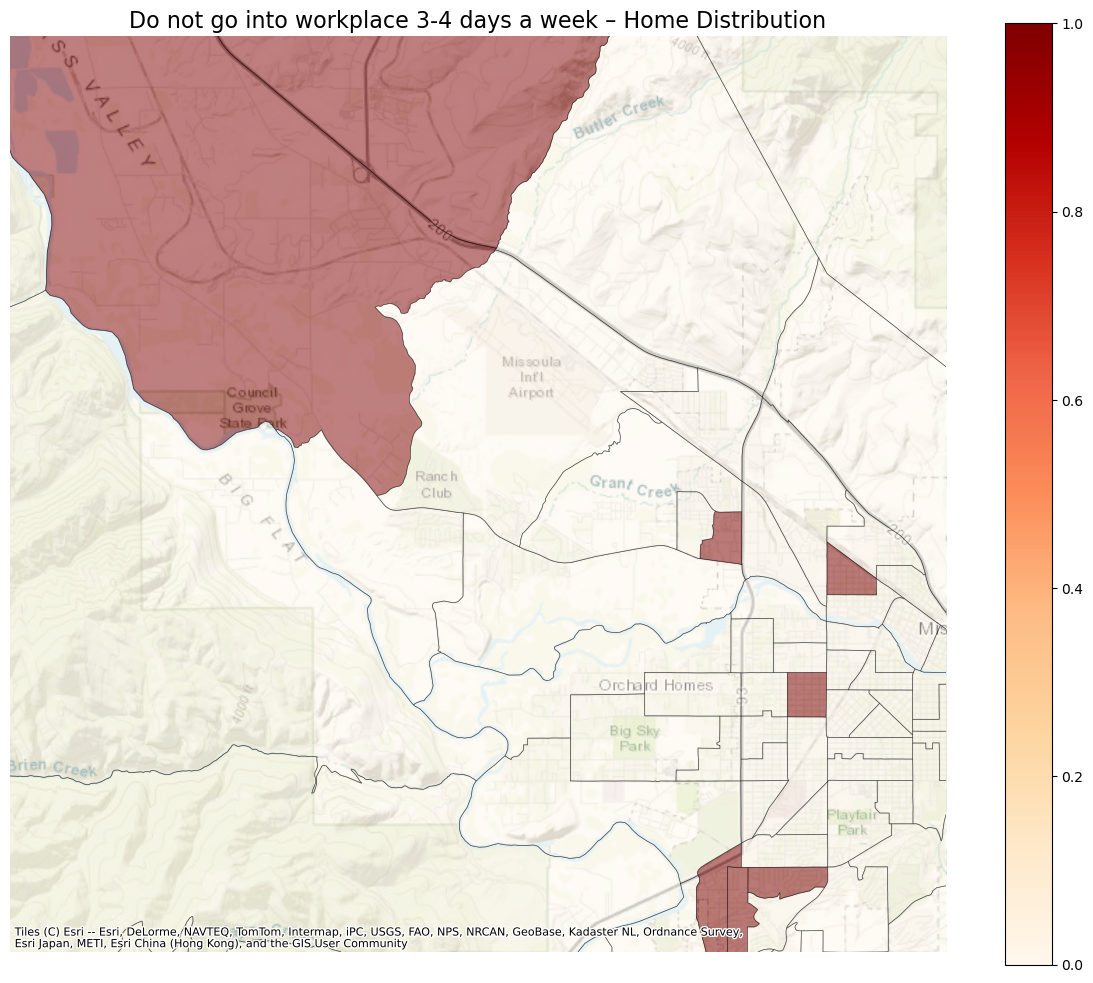

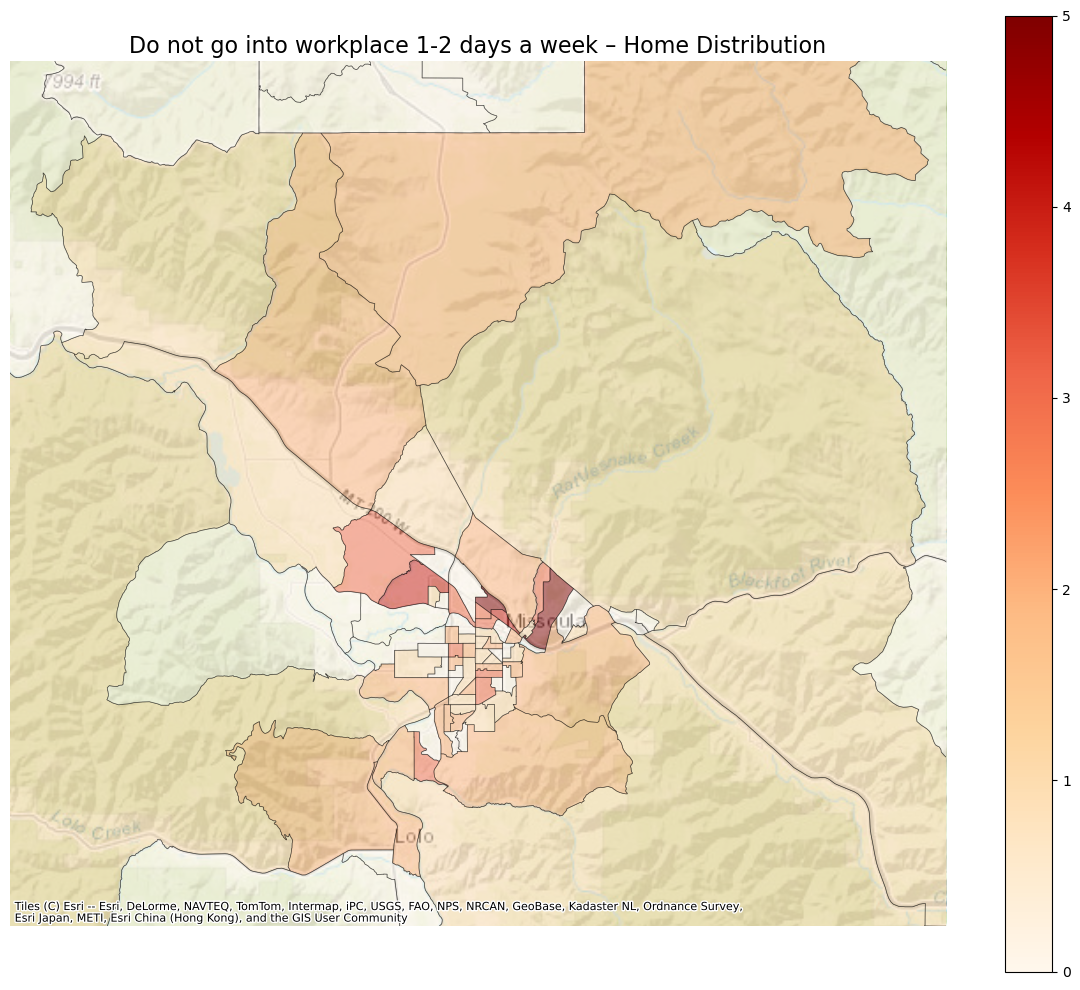

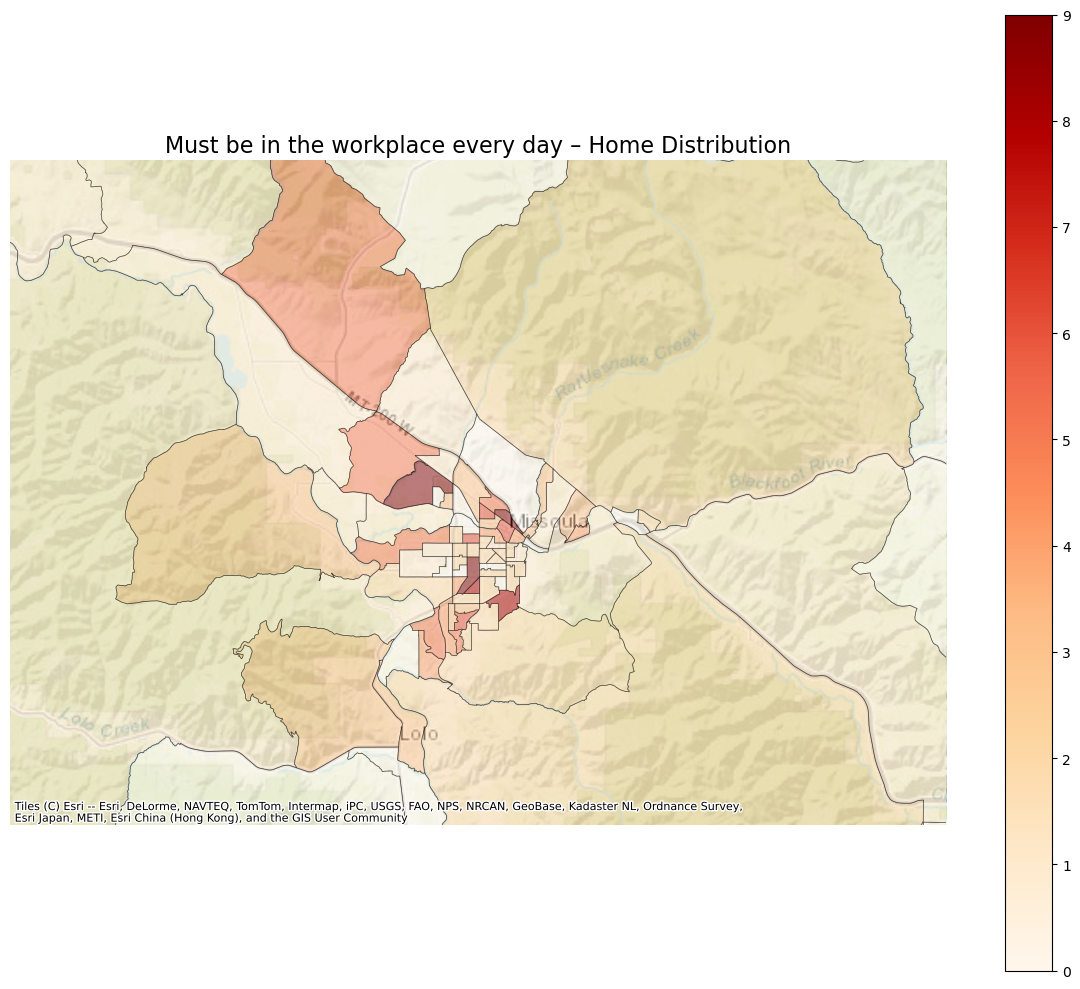

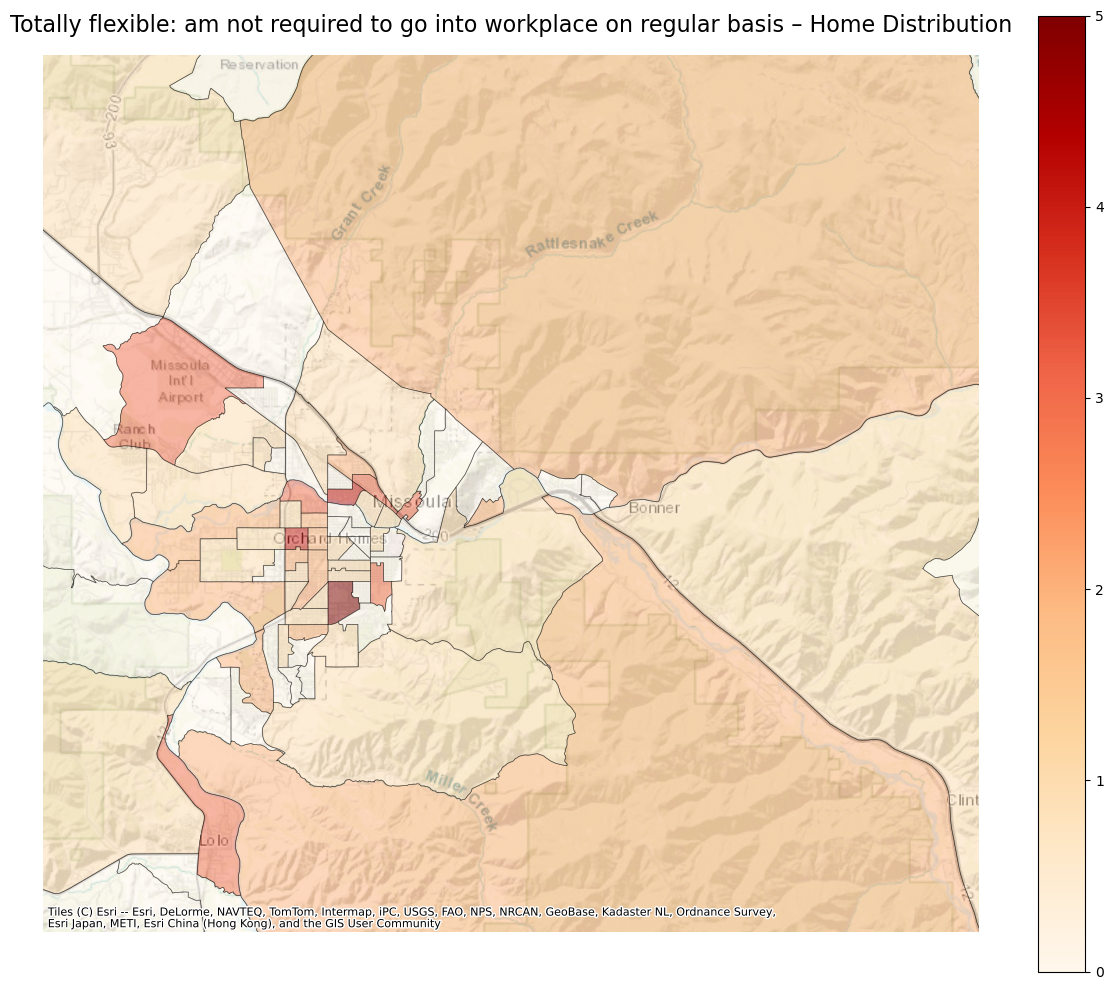

In [9]:
# Plot all remote policy groups by home
for policy in REMOTE_POLICY_GROUPS:
    plot_group_map(df, REMOTE_POLICY_COL, policy, address_type="home", title=f"{policy} – Home Distribution")

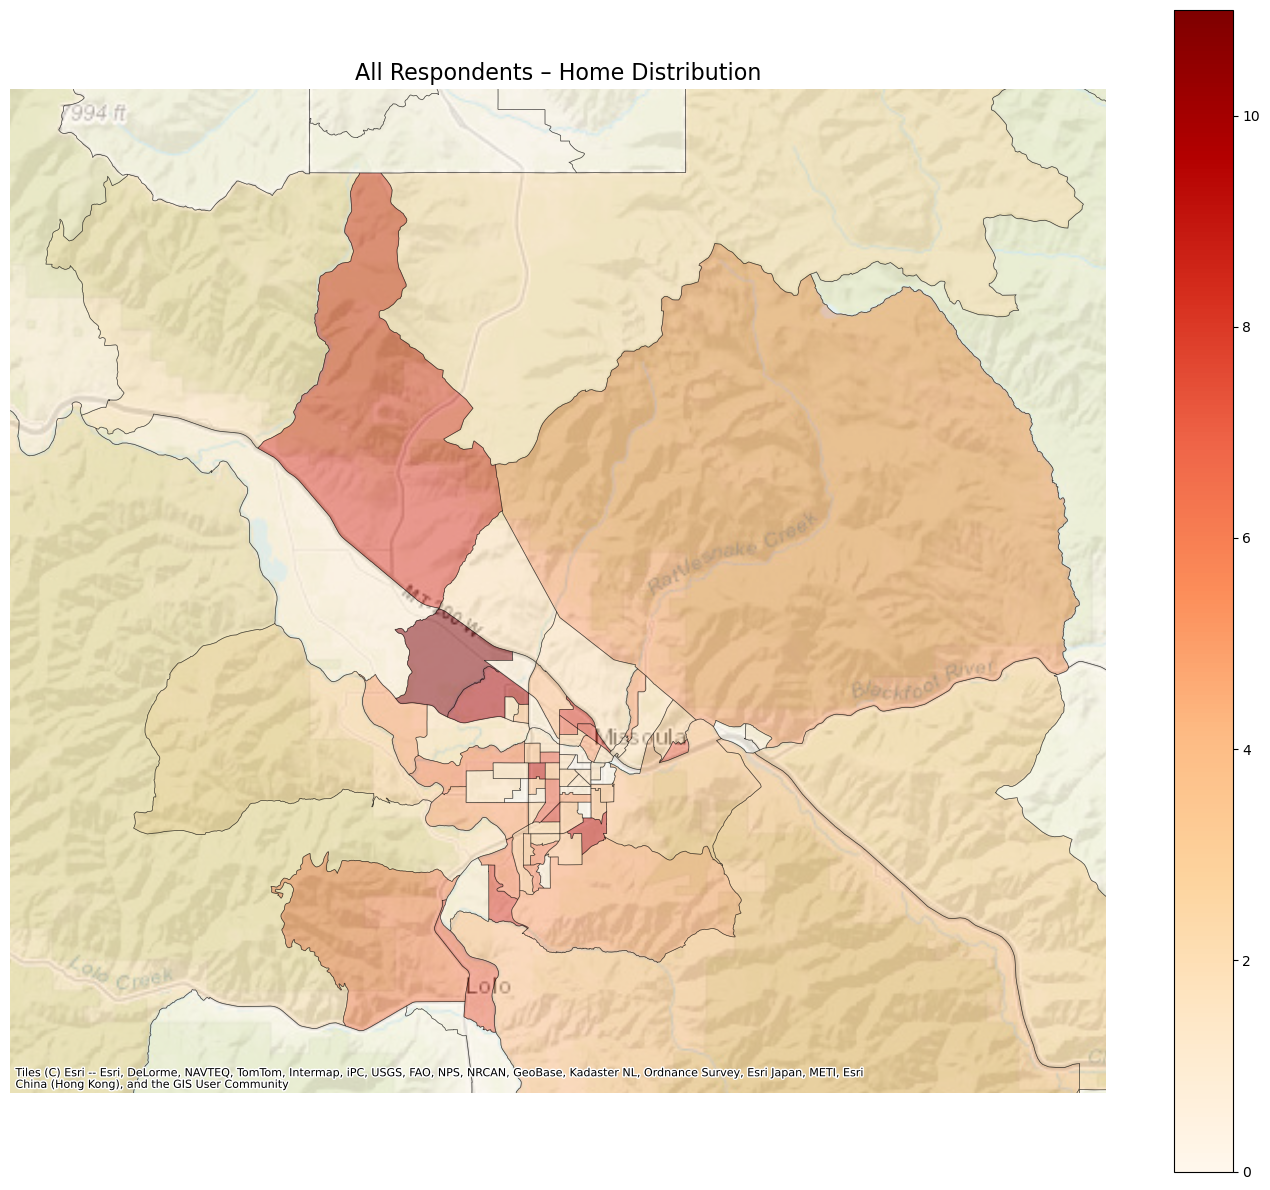

In [13]:
plot_group_map(df, filter_col=COMMUTE_MODE_COL, filter_val=df[COMMUTE_MODE_COL].iloc[0], address_type="home", title="All Respondents – Home Distribution")

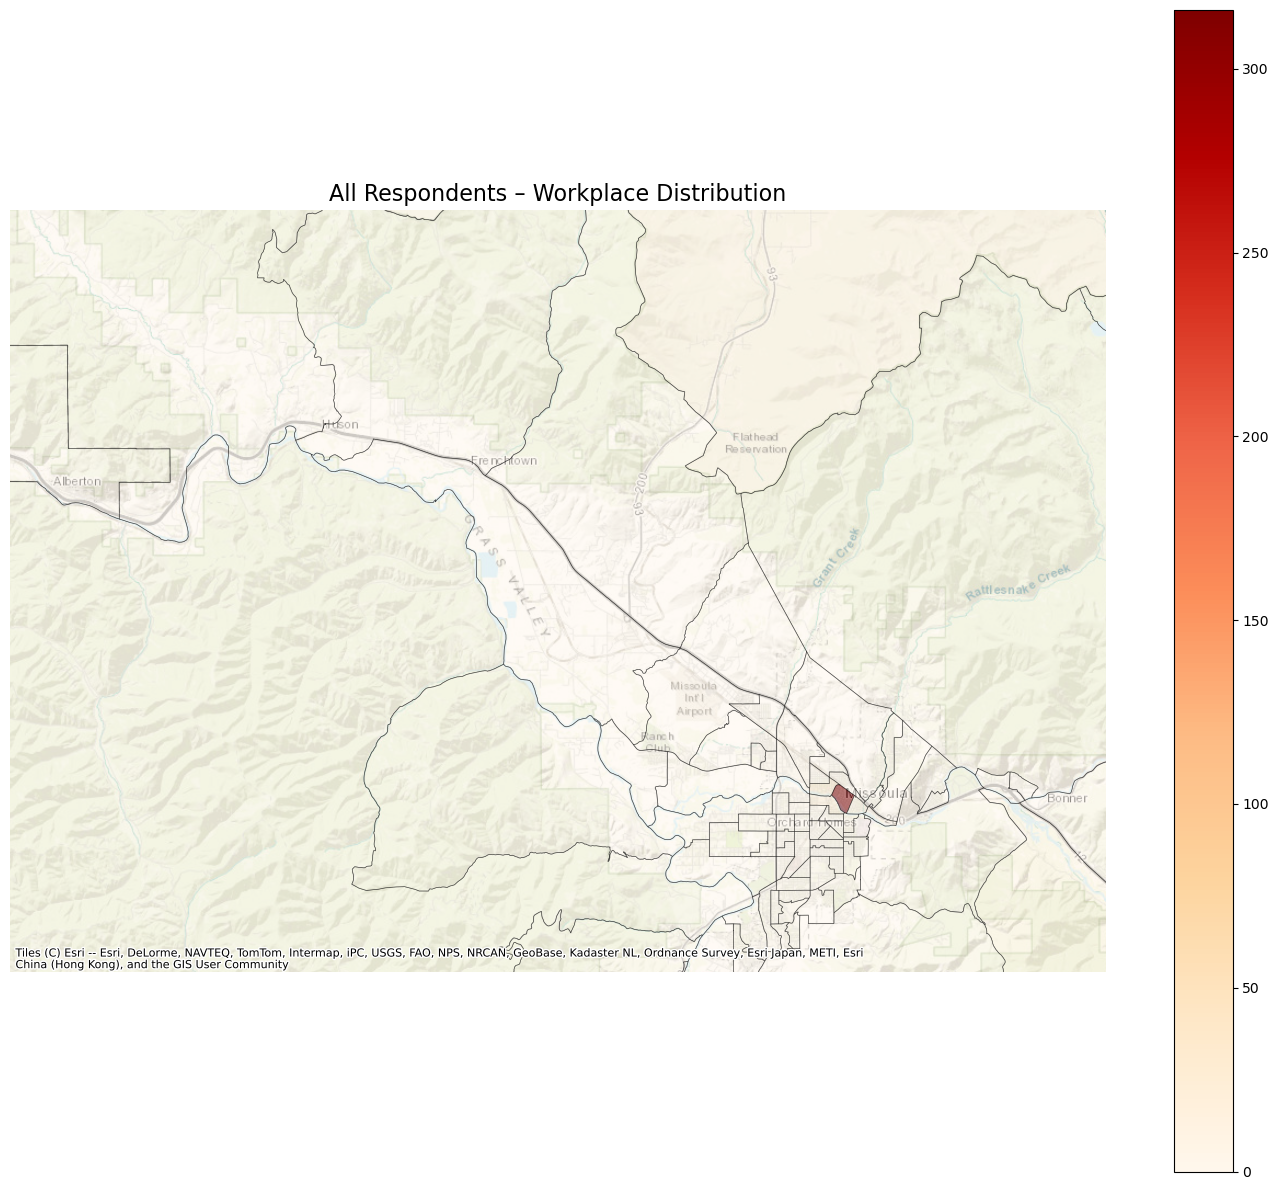

In [14]:
plot_group_map(df, filter_col=COMMUTE_MODE_COL, filter_val=df[COMMUTE_MODE_COL].iloc[0], address_type="work", title="All Respondents – Workplace Distribution")